In [144]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [145]:
## Load and clean data
# Load data for RI (rows represent traffic stops)
ri = pd.read_csv('police.csv', low_memory=False)

# Look at first few lines
# print(ri.head())

# Determine how many values are missing
# print(ri.isnull().sum())

# Remove county_name, county_fips, and fine_grained_location columns since all entries are missing
ri.drop(['county_name', 'county_fips', 'fine_grained_location'], axis='columns', inplace=True)

# Remove rows with missing stop outcome, driver gender, driver age, or out_of_state
ri.dropna(subset=['stop_outcome', 'driver_gender', 'driver_age', 'out_of_state'], inplace=True)

# Check how many values are missing now
print(ri.isnull().sum())

id                         0
state                      0
stop_date                  0
stop_time                  0
location_raw               0
police_department          0
driver_gender              0
driver_age_raw             0
driver_age                 0
driver_race_raw            0
driver_race                0
violation_raw              0
violation                  0
search_conducted           0
search_type_raw       460550
search_type           460550
contraband_found           0
stop_outcome               0
is_arrested                0
stop_duration              0
out_of_state               0
drugs_related_stop         0
district                   0
dtype: int64


In [146]:
## Continue cleaning process by modifying datatypes
# Examine datatypes of entries
ri.dtypes

# Change the datatype of is_arrested to 'bool'
ri['is_arrested'] = ri.is_arrested.astype('bool')

# Change the datatype of search_conducted to 'bool'
ri['search_conducted'] = ri.search_conducted.astype('bool')

# Combine stop_date and stop_time into datetime format
ri['stop_datetime'] = pd.to_datetime(ri.stop_date.str.cat(ri.stop_time, sep=' '))

# Set the stop_datetime column as the index of the dataframe
ri.set_index('stop_datetime', inplace=True)

In [147]:
## Do drivers of different genders commit different types of traffic violations?
# Count the unique values in 'violation'
print(ri.violation.value_counts())

# Express the counts as proportions
print(ri.violation.value_counts(normalize=True))

# Create a DataFrame of female drivers
female = ri[ri.driver_gender == 'F']

# Create a DataFrame of male drivers
male = ri[ri.driver_gender == 'M']

# Compute the violations by female drivers (as proportions)
print(female.violation.value_counts(normalize=True)) # Almost 2/3 of female violations are speeding

# Compute the violations by male drivers (as proportions)
print(male.violation.value_counts(normalize=True)) # About 1/2 of male violations are speeding

Speeding               267931
Moving violation        89738
Equipment               61068
Other                   23431
Registration/plates     19780
Seat belt               16290
Name: violation, dtype: int64
Speeding               0.560246
Moving violation       0.187643
Equipment              0.127694
Other                  0.048994
Registration/plates    0.041360
Seat belt              0.034063
Name: violation, dtype: float64
Speeding               0.657675
Moving violation       0.136546
Equipment              0.107152
Registration/plates    0.043146
Other                  0.028384
Seat belt              0.027098
Name: violation, dtype: float64
Speeding               0.523616
Moving violation       0.206854
Equipment              0.135417
Other                  0.056744
Registration/plates    0.040689
Seat belt              0.036681
Name: violation, dtype: float64


In [157]:
## Is there a correlation between gender and getting a ticket for speeding?
# Create a DataFrame of female drivers stopped for speeding
female_and_speeding = ri[(ri.driver_gender == 'F') & (ri.violation == 'Speeding')]

# Create a DataFrame of male drivers stopped for speeding
male_and_speeding = ri[(ri.driver_gender == 'M') & (ri.violation == 'Speeding')]

# Compute the stop outcomes for female drivers (as proportions)
print("Stop outcomes for female drivers:")
print(female_and_speeding.stop_outcome.value_counts(normalize=True)) # 95.4% ticketed

# Compute the stop outcomes for male drivers (as proportions)
print("Stop outcomes for male drivers:")
print(male_and_speeding.stop_outcome.value_counts(normalize=True)) # 94.6% ticketed

# Conclusion: Proportions for getting a speeding ticket are about the same

Stop outcomes for female drivers:
Citation            0.954306
Warning             0.037945
Arrest Driver       0.005294
Arrest Passenger    0.001036
N/D                 0.000896
No Action           0.000524
Name: stop_outcome, dtype: float64
Stop outcomes for male drivers:
Citation            0.945744
Warning             0.034985
Arrest Driver       0.015787
Arrest Passenger    0.001258
N/D                 0.001181
No Action           0.001044
Name: stop_outcome, dtype: float64


In [158]:
## Is there a correlation between gender and car getting searched?
# Calculate the overall search rate by taking the mean
print("Overall search rate:", ri.search_conducted.mean())

# Calculate the search rate for both female and male drivers simultaneously
print(ri.groupby('driver_gender').search_conducted.mean()) # 1.9% for females and 4.4% for males

# Difference could be due to violation type
# Calculate the search rate for each combination of gender and violation
print(ri.groupby(['violation', 'driver_gender']).search_conducted.mean())

# Conclusion: The search rate is higher for males than for females, regardless of violation type (except about the same for 'Other')

Overall search rate: 0.03698576859220723
driver_gender
F    0.018749
M    0.043842
Name: search_conducted, dtype: float64
violation            driver_gender
Equipment            F                0.040280
                     M                0.071007
Moving violation     F                0.037998
                     M                0.059225
Other                F                0.046374
                     M                0.047155
Registration/plates  F                0.054629
                     M                0.103380
Seat belt            F                0.017509
                     M                0.031532
Speeding             F                0.007750
                     M                0.026617
Name: search_conducted, dtype: float64


In [150]:
## Is there a correlation between gender and getting frisked?
# Examine the different search types and relative proportions
ri.search_type.value_counts(dropna=False) # Majority NaN because not searched; multiple types separated by commas

# Count the 'search_type' values
print(ri.search_type.value_counts())

# Check if 'search_type' contains the string 'Protective Frisk'
ri['frisk'] = ri.search_type.str.contains('Protective Frisk', na=False)

# Take the sum of 'frisk'
print(ri.frisk.sum())

# Create a DataFrame of stops in which a search was conducted
searched = ri[ri.search_conducted == True]

# Calculate the overall frisk rate by taking the mean of 'frisk'
print(searched.frisk.mean())

# Calculate the frisk rate for each gender
print(searched.groupby('driver_gender').frisk.mean())

# Conclusion: The frisk rate is higher for males than for females (9.3% vs. 6.7%)

Incident to Arrest                                          6968
Probable Cause                                              4968
Reasonable Suspicion                                        1140
Inventory                                                   1095
Protective Frisk                                             875
Incident to Arrest,Inventory                                 649
Incident to Arrest,Probable Cause                            548
Probable Cause,Reasonable Suspicion                          333
Probable Cause,Protective Frisk                              220
Incident to Arrest,Protective Frisk                          156
Incident to Arrest,Inventory,Probable Cause                  151
Inventory,Probable Cause                                     132
Protective Frisk,Reasonable Suspicion                         82
Incident to Arrest,Inventory,Protective Frisk                 77
Incident to Arrest,Probable Cause,Protective Frisk            73
Inventory,Protective Fris

0.034553925033142495


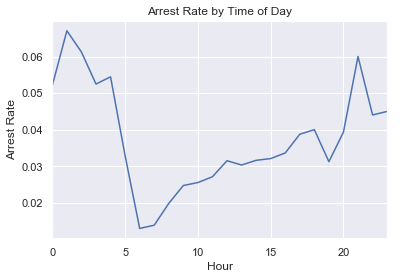

In [151]:
## Is there a correlation between time of day and arrest rate?
# Calculate the overall arrest rate
print(ri.is_arrested.mean()) # Approximately 3.5%

# Calculate and save the hourly arrest rate
hourly_arrest_rate = ri.groupby(ri.index.hour).is_arrested.mean()

# Create a line plot of 'hourly_arrest_rate'
hourly_arrest_rate.plot()

# Add the xlabel, ylabel, and title
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')

# Display the plot
plt.show()

# Conclusion: The arrest rate is higher during overnight

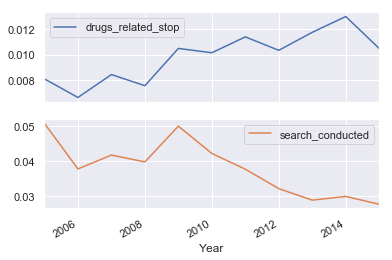

In [152]:
## How has number of drug-related stops changed over time?
## Is this correlated to how many searches are conducted?
# Calculate and save the annual rate of drug-related stops
annual_drug_rate = ri.drugs_related_stop.resample('A').mean()

# Calculate and save the annual search rate
annual_search_rate = ri.search_conducted.resample('A').mean()

# Concatenate 'annual_drug_rate' and 'annual_search_rate'
annual = pd.concat([annual_drug_rate, annual_search_rate], axis='columns')

# Create line plots with subplots from 'annual'
annual.plot(subplots=True)

# Add the xlabel
plt.xlabel('Year')

# Display the subplots
plt.show()

# Conclusion: Drug-related stops have increased over time, but number of searches conducted
# have decreased during the same time period, so they are not directly correlated

['Zone K1' 'Zone X4' 'Zone X1' 'Zone K3' 'Zone X3' 'Zone K2']


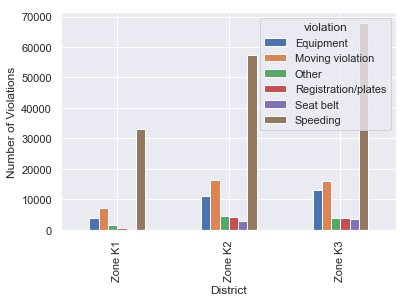

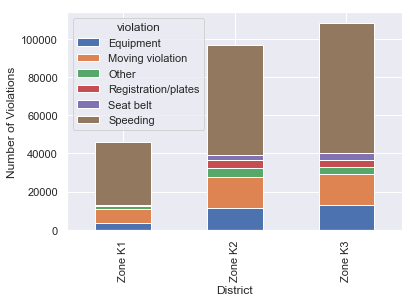

In [153]:
## Is there a difference in different districts concerning what violations are caught?
# Print the different police districts
print(ri.district.unique())

# Create and save a frequency table of districts and violations
all_zones = pd.crosstab(ri.district, ri.violation)

# Select rows 'Zone K1' through 'Zone K3' and save the smaller table as 'k_zones'
k_zones = all_zones.loc['Zone K1':'Zone K3']

# Create a bar plot of 'k_zones'
k_zones.plot(kind='bar')

# Add labels
plt.xlabel('District')
plt.ylabel('Number of Violations')

# Display the plot
plt.show()

# Create a stacked bar plot of 'k_zones'
k_zones.plot(kind='bar', stacked=True)

# Add labels
plt.xlabel('District')
plt.ylabel('Number of Violations')

# Display the plot
plt.show()

# Conclusion: Zones K2 and K3 are very similar, except for more speeding violations in K3. There are fewer
# violations overall in K1, and overall seems proportional to K2

['0-15 Min' '16-30 Min' '30+ Min' '2' '1']
[  8  23  45 120  60]


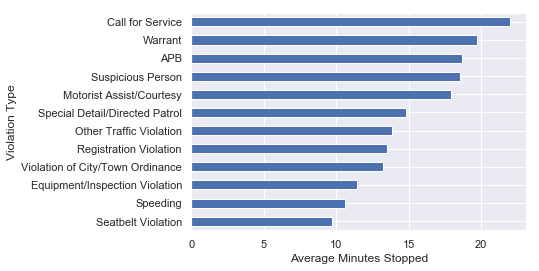

In [154]:
## How long are you stopped after particular violations?
# Print the unique values in 'stop_duration'
print(ri.stop_duration.unique())

# Create a dictionary that maps 'stop_duration' strings to integers representing minutes stopped
mapping = {'0-15 Min':8, '16-30 Min':23, '30+ Min':45, '1':60, '2':120}

# Convert the 'stop_duration' strings to integers using the 'mapping' dictionary
ri['stop_minutes'] = ri.stop_duration.map(mapping)

# Print the unique values in 'stop_minutes'
print(ri.stop_minutes.unique())

# Calculate and save the mean 'stop_minutes' for each value in 'violation_raw'
stop_length = ri.groupby('violation_raw').stop_minutes.mean()

# Sort 'stop_length' by its values and create a horizontal bar plot
stop_length.sort_values().plot(kind='barh')

# Add labels
plt.xlabel('Average Minutes Stopped')
plt.ylabel('Violation Type')

# Display the plot
plt.show()

# Conclusion: We see that 'Call for Service' resulted in the most average time stopped while relatively simpler
# violations such as 'Seatbelt' and 'Speeding' resulted in the least average time stopped (around 10 min or less)

              TMIN         TAVG         TMAX
count  7091.000000  4283.000000  7091.000000
mean     43.146383    51.896801    60.886758
std      16.945370    17.333584    18.185458
min      -9.000000     0.000000    10.000000
25%      30.000000    38.000000    46.000000
50%      43.000000    52.000000    62.000000
75%      58.000000    67.000000    76.000000
max      78.000000    88.000000   102.000000


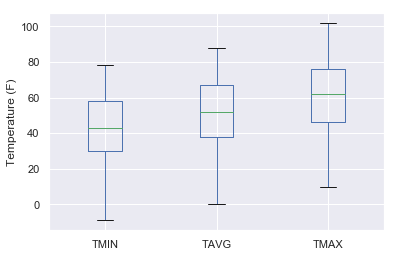

count    7091.000000
mean       17.740375
std         6.370075
min         2.000000
25%        13.000000
50%        18.000000
75%        22.000000
max        47.000000
Name: TDIFF, dtype: float64


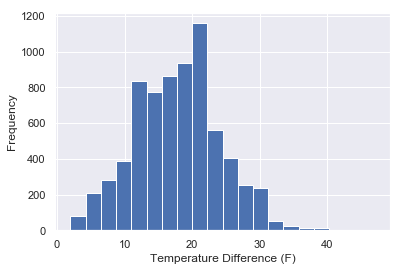

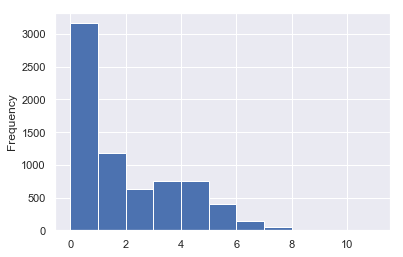

0     3166
1     1188
2      628
3      748
4      753
5      399
6      138
7       53
8       10
9        6
11       2
Name: bad_conditions, dtype: int64
bad      3317
good     3166
worse     606
worst       2
Name: rating, dtype: int64


/Users/wyssuser/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  exec(code_obj, self.user_global_ns, self.user_ns)


In [155]:
## Does weather affect policing activity?

## Read in weather data and make sure it is reasonable
# Want max greater than min, with difference close to a normal distribution
# Read 'weather.csv' into a DataFrame named 'weather'
weather = pd.read_csv('weather.csv')

# Get a feel for the distribution of the temperature columns
print(weather[['TMIN', 'TAVG', 'TMAX']].describe())

# Create a box plot of the temperature columns
weather[['TMIN', 'TAVG', 'TMAX']].plot(kind='box')

# Add labels
plt.ylabel('Temperature (F)')

# Display the plot
plt.show()

# Create a 'TDIFF' column that represents temperature difference
weather['TDIFF'] = weather.TMAX-weather.TMIN

# Describe the 'TDIFF' column
print(weather.TDIFF.describe())

# Create a histogram with 20 bins to visualize 'TDIFF'
weather.TDIFF.plot(kind='hist', bins=20)

# Add labels
plt.xlabel('Temperature Difference (F)')

# Display the plot
plt.show()

## Get general idea of bad weather condition distributions
## WT = weather type (e.g., WT05 is "Hail" and WT11 is "High or damaging winds")
# Copy 'WT01' through 'WT22' to a new DataFrame
WT = weather.loc[:, 'WT01':'WT22']

# Calculate the sum of each row in 'WT'
weather['bad_conditions'] = WT.sum(axis='columns')

# Replace missing values in 'bad_conditions' with '0'
weather['bad_conditions'] = weather.bad_conditions.fillna(0).astype('int')

# Create a histogram to visualize 'bad_conditions'
weather.bad_conditions.plot(kind='hist', bins=11)

# Display the plot
plt.show() # Most days did not have any bad weather conditions

# Count the unique values in 'bad_conditions' and sort the index
print(weather.bad_conditions.value_counts().sort_index()) # 0 up to 11

# Create a dictionary that maps integers to strings
mapping = {0:'good', 1:'bad', 2:'bad', 3:'bad', 4:'bad',
    5:'worse', 6:'worse', 7:'worse', 8:'worse', 9:'worse', 11:'worst'}

# Convert the 'bad_conditions' integers to strings using the 'mapping'
weather['rating'] = weather.bad_conditions.map(mapping)

# Count the unique values in 'rating'
print(weather.rating.value_counts())

# Change the data type of 'rating' to category with correct order
weather['rating'] = weather.rating.astype('category', ordered=True, categories=['good', 'bad', 'worse', 'worst'])

rating                   good       bad     worse
violation                                        
Equipment            0.056433  0.059746  0.094713
Moving violation     0.055591  0.058010  0.062381
Other                0.084120  0.086477  0.060688
Registration/plates  0.076806  0.092517  0.099016
Seat belt            0.025453  0.028751  0.000000
Speeding             0.013229  0.013375  0.016615


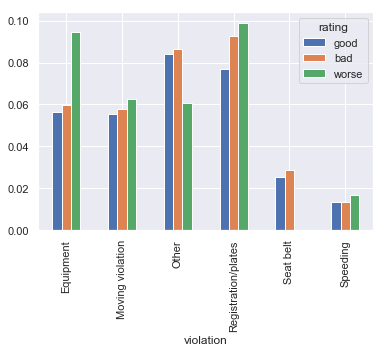

In [156]:
## Combine policing data with weather data
# Reset the index of 'ri'
ri.reset_index(inplace=True)

# Create a DataFrame from the 'DATE' and 'rating' columns of weather data
weather_rating = weather[['DATE', 'rating']]

# Merge 'ri' and 'weather_rating' using a left join
ri_weather = pd.merge(left=ri, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')

# Set 'stop_datetime' as the index of 'ri_weather'
ri_weather.set_index('stop_datetime', inplace=True)

# Examine head of merged dataframe to make sure merge was successful
ri_weather.head()

## Examine if there is a correlation between arrest rate and weather rating
# Calculate the arrest rate for each 'violation' and 'rating'
arrest_rate = ri_weather.groupby(['violation', 'rating']).is_arrested.mean()

# Unstack the 'arrest_rate' Series into a DataFrame
print(arrest_rate.unstack())

# Create the same DataFrame using a pivot table and a bar graph to visualize the arrest rates vs. weather condition
ri_weather.pivot_table(index='violation', columns='rating', values='is_arrested').plot(kind='bar')

# Display the plot
plt.show()

# Conclusion: Arrest rates increase as weather gets worse for most violations except for 'Other' and 'Seat belt'
# (for the worst weather condition)